Author: Alonso Menéndez González

This notebook contains the code necessary to analyze the resultant distributions my means of 5 different techniques, comprising the Third and Fourth step in the Fault Detection System.

In Section 2, the data will be loaded in memory from a csv file containing the distributions (means and variances). Afterwards, the healthy distributions are selected to compute the General Healthy Distribution in Section 3. Finally, Section 4 will apply 5 methods to look for early indicators of faults.

**Please note:** This code was written as a Google Colab Notebook. Therefore, several changes must be made before executing it.

**Table of contents**<a id='toc0_'></a>    
- [1. Imports](#toc1_)    
- [2. Data loading](#toc2_)    
    - [Load and Split](#toc2_1_1_)    
    - [Summary](#toc2_1_2_)    
- [3. General Healthy Distribution](#toc3_)    
- [4. Computations](#toc4_)    
  - [Opc1: Kolmogonov-Smirnov Test](#toc4_1_)    
    - [Computations](#toc4_1_1_)    
    - [Result](#toc4_1_2_)    
  - [Opc2: Kulback Leibler Divergence](#toc4_2_)    
    - [Function](#toc4_2_1_)    
    - [KL for healthy distributions](#toc4_2_2_)    
    - [Threshold](#toc4_2_3_)    
    - [Window](#toc4_2_4_)    
    - [Result](#toc4_2_5_)    
  - [Opc3: KL over Prior](#toc4_3_)    
  - [Opc4: Entropy](#toc4_4_)    
    - [Computations](#toc4_4_1_)    
    - [Result](#toc4_4_2_)    
  - [Opc5: Variance](#toc4_5_)    
    - [Computations](#toc4_5_1_)    
    - [Result](#toc4_5_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[1. Imports](#toc0_)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
from scipy.stats import norm
import pandas as pd
from scipy import stats
import math
import matplotlib.pyplot as plt

# <a id='toc2_'></a>[2. Data loading](#toc0_)

In [ ]:
# These are some of the filenames that I used. See VAE-IMS or VAE-XJTU to see how to obtain them
filename = "XJTU-2-1-mean-var.csv" #"IMS-2-mean-var.csv" #"IMS-1-QuadChannel-mean-var.csv" #"IMS-1-Quadz-QuadChannel-mean-var.csv" #"IMS-3-mean-var.csv" #"XJTU-3-4-mean-var.csv"
name = "XJTU-SY-2-1" #"IMS-2" #"IMS-1" #"XJTU-SY-3-4" #<- The name for the plots to be created

### <a id='toc2_1_1_'></a>[Load and Split](#toc0_)

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/TFM/MeanVars/"+filename).iloc[:,1:]

In [ ]:
healthy = data.iloc[:300,:]
unlabeled = data.iloc[300:,:]

### <a id='toc2_1_2_'></a>[Summary](#toc0_)

In [ ]:
healthy

,mu_x,var_x
0,3.700047,0.000343
1,-1.325155,0.001761
2,0.264057,0.000689
3,-3.889127,0.006104
4,1.318104,0.000206
...,...,...
295,0.038983,0.000482
296,-1.007463,0.002106
297,2.010183,0.000332
298,-0.829804,0.008217


In [52]:
unlabeled

,mu_x,var_x
300,0.422890,8.766039e-02
301,0.000911,5.915025e-02
302,0.403130,7.494462e-02
303,-1.418913,6.853168e-02
304,1.487223,9.999129e-02
...,...,...
485,2.961021,7.818502e-09
486,10.884431,3.473434e-08
487,-0.739769,2.875830e-06
488,-17.319660,8.312758e-09


array([[<Axes: title={'center': 'mu_x'}>,
        <Axes: title={'center': 'var_x'}>]], dtype=object)

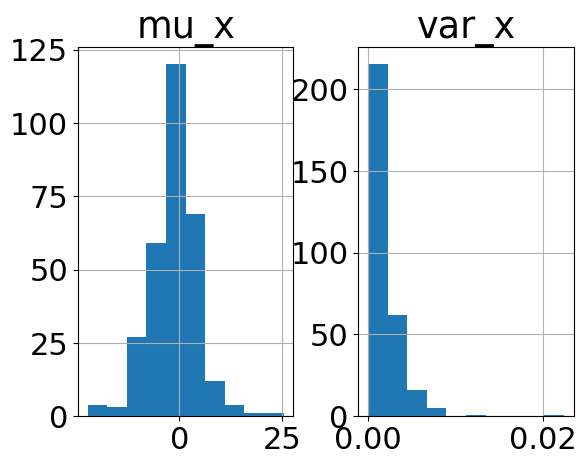

In [ ]:
healthy.hist()

# <a id='toc3_'></a>[3. General Healthy Distribution](#toc0_)

This is a must for Opc1 and 2

In [ ]:
mu_healthy, var_healthy = healthy.mean()

In [ ]:
mu_healthy

-2.3042776703834535

In [ ]:
var_healthy

0.05259302790587142

# <a id='toc4_'></a>[4. Computations](#toc0_)

## <a id='toc4_1_'></a>[Opc1: Kolmogonov-Smirnov Test](#toc0_)

### <a id='toc4_1_1_'></a>[Computations](#toc0_)

In [ ]:
n_samples = 1000  # Número de muestras
healthy_samples = np.random.normal(mu_healthy, np.sqrt(var_healthy), n_samples)

In [53]:
def ks_test(mu_x, var_x, healthy_samples, p_thr=0.05, n_samples=1000):

  data2 = np.random.normal(mu_x, np.sqrt(var_x), n_samples)
  statistic, p_value = stats.ks_2samp(healthy_samples, data2)

  # Compara el valor p con el nivel de significancia (por ejemplo, 0.05)
  if p_value < p_thr:
    different = True
  else:
    different = False

  return different, p_value


In [54]:
res = healthy.apply(lambda x: ks_test(mu_x=x["mu_x"], var_x=x["var_x"], healthy_samples = healthy_samples), axis=1)
healthy_ks = pd.DataFrame(res.tolist(), columns=['is_different', 'p_value'])
healthy_ks

,is_different,p_value
0,True,0.000000e+00
1,True,0.000000e+00
2,True,0.000000e+00
3,True,1.080386e-230
4,True,0.000000e+00
...,...,...
295,True,0.000000e+00
296,True,0.000000e+00
297,True,0.000000e+00
298,True,0.000000e+00


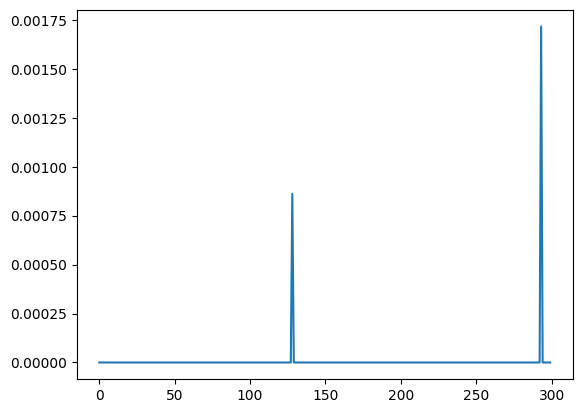

In [55]:
import matplotlib.pyplot as plt

# Grafica los valores de Columna2
healthy_ks["p_value"].plot()#kind='line', marker='o', grid=True)
#plt.xlabel('Columna1')
#plt.ylabel('Columna2')
#plt.title('Valores de Columna2')
plt.show()

In [ ]:
res = unlabeled.apply(lambda x: ks_test(mu_x=x["mu_x"], var_x=x["var_x"], healthy_samples = healthy_samples), axis=1)
unlabeled_ks = pd.DataFrame(res.tolist(), columns=['is_different', 'p_value'], index=range(301, 301 + len(res)))
unlabeled_ks

,is_different,p_value
301,True,0.000000e+00
302,True,0.000000e+00
303,True,0.000000e+00
304,True,0.000000e+00
305,True,0.000000e+00
...,...,...
979,True,0.000000e+00
980,True,0.000000e+00
981,True,1.739387e-310
982,True,8.032255e-96


### <a id='toc4_1_2_'></a>[Result](#toc0_)

In [ ]:
res = data.apply(lambda x: ks_test(mu_x=x["mu_x"], var_x=x["var_x"], healthy_samples = healthy_samples), axis=1)
data_ks = pd.DataFrame(res.tolist(), columns=['is_different', 'p_value'])
data_ks['is_different'].value_counts()

,count
is_different,
True,982
False,1


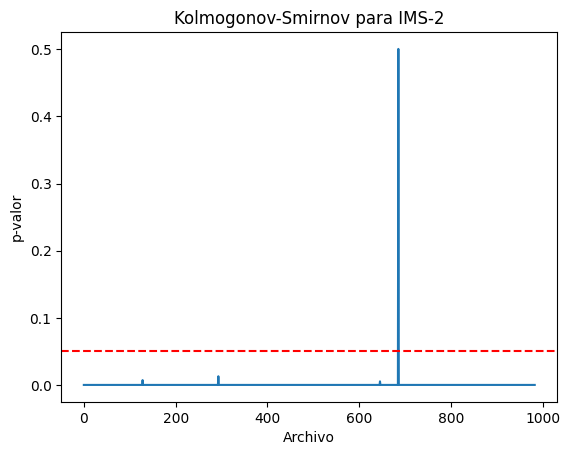

In [58]:
# Grafica los valores de Columna2
data_ks["p_value"].plot()#kind='line', marker='o', grid=True)
plt.xlabel('Archivo')
plt.ylabel('p-valor')
plt.title('Kolmogonov-Smirnov para ' + name)
plt.axhline(y=0.05, color='red', linestyle='--', label="Umbral (y=0.05)")
plt.show()

In [60]:
data_ks["p_value"]

,p_value
0,0.000000e+00
1,0.000000e+00
2,0.000000e+00
3,5.789179e-239
4,0.000000e+00
...,...
978,0.000000e+00
979,0.000000e+00
980,0.000000e+00
981,7.175493e-99


In [ ]:
data_ks["p_value"].to_csv(f"/content/drive/MyDrive/TFM/MeanVars/{name}-KS.csv")

## <a id='toc4_2_'></a>[Opc2: Kulback Leibler Divergence](#toc0_)

### <a id='toc4_2_1_'></a>[Function](#toc0_)

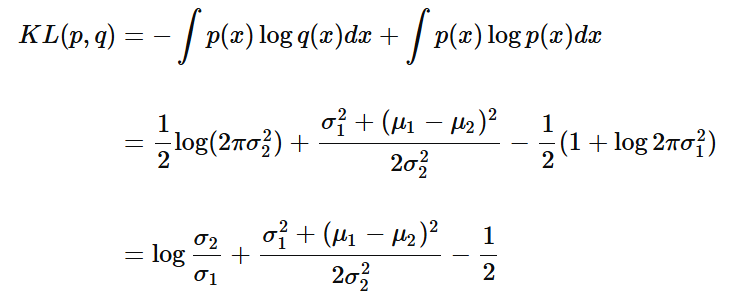

In [ ]:
def kl_divergence(mu1, mu2, var1, var2):
    desv1=math.sqrt(var1)
    desv2=math.sqrt(var2)

    p1 = math.log(desv2/desv1)
    p2 = (var1 + math.pow(mu1 - mu2,2)) / (2*var2)
    p3 = -1/2

    kl_value = p1 + p2 + p3

    return kl_value

### <a id='toc4_2_2_'></a>[KL for healthy distributions](#toc0_)

In [13]:
kl_healthy = healthy.apply(lambda x: kl_divergence(mu1=mu_healthy, mu2=x["mu_x"], var1=var_healthy, var2=x["var_x"]), axis=1)

<Axes: >

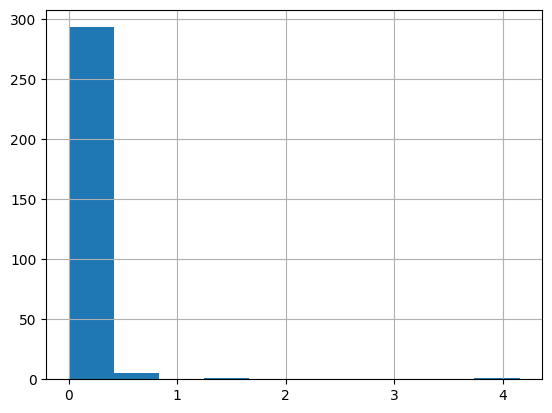

In [ ]:
kl_healthy.hist()

### <a id='toc4_2_3_'></a>[Threshold](#toc0_)

In [ ]:
kl_total = pd.DataFrame(columns=["valor","is_different"])

In [20]:
kl_total["valor"] = data.apply(lambda x: kl_divergence(mu1=mu_healthy, mu2=x["mu_x"], var1=var_healthy, var2=x["var_x"]), axis=1)

In [21]:
thr = np.percentile(kl_healthy.apply(lambda x: math.log(x,10)), 95)


In [ ]:
kl_total["is_different"] = kl_total["valor"].apply(lambda x: math.log(x,10) > thr)

### <a id='toc4_2_4_'></a>[Window](#toc0_)

In [23]:
def get_alert(data, window_size, n_true):
  for i in range(len(data) - window_size + 1):
    window = data[i:i + window_size]
    if window.sum() >= 4:
      return i+window_size

  return len(data) +1

In [24]:
alarma = get_alert(kl_total["is_different"], 5,4)

In [25]:
alarma

2004

In [26]:
kl_total

,valor,is_different
0,0.002680,False
1,0.003699,False
2,0.005167,False
3,0.000605,False
4,0.000067,False
...,...,...
2150,1.200292,True
2151,0.005870,False
2152,1.212508,True
2153,1.195048,True


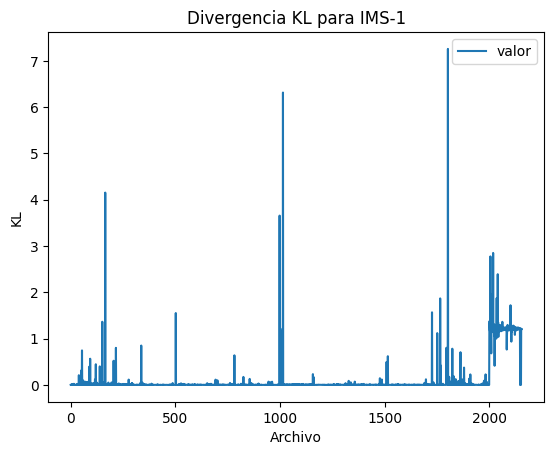

In [27]:
kl_total.plot()#kind='line', marker='o', grid=True)
plt.xlabel('Archivo')
plt.ylabel('KL')
plt.title('Divergencia KL para ' + name)
#plt.axhline(y=0.05, color='red', linestyle='--', label="Umbral (y=0.05)")
#plt.ylim(0,10)
plt.show()

In [28]:
def plot_figure(df, alarma, thr, name, width, height, linewidth=1,point_size=5, ylim=None, xlim_i=None, xlim_s=None):
  fig, ax = plt.subplots(figsize=(width,height))

  x_values = range(len(df))
  y_values = df['valor']
  is_different = df['is_different']



  ax.axvspan(0, 300, facecolor='lightgreen', alpha=0.5, label='Saludables (X < 300)')
  ax.axvspan(300, alarma, facecolor='lightyellow', alpha=1, label=f'Categorizada saludable (X < {alarma})')

  if alarma < len(df):
    ax.axvspan(alarma, len(df), facecolor='pink', alpha=0.5, label=f'Categorizada fallo (X >= {alarma})')

  # Gráfico de línea
  ax.plot(x_values, y_values, alpha=0.8, linewidth=1)

  # Gráfico de dispersión con puntos coloreados
  ax.scatter(x_values, y_values, c=is_different, cmap='coolwarm', s=5)



  # Agregar una línea horizontal en el valor de umbral
  ax.axhline(y=thr, color='red', linestyle='--', alpha=0.8, label=f"Umbral (y={thr:.4f})")

  # Agregar etiquetas y título
  ax.set_xlabel('Archivo')
  ax.set_ylabel('KL - Escala Log10')
  ax.set_title(f'División del estado de salud con la Divergencia KL:  {name}')
  if ylim is not None:
    ax.set_ylim(0, ylim)
  if xlim_i is None:
    ax.set_xlim(0, len(df))
  else:
    ax.set_xlim(xlim_i, xlim_s)

  # Agregar fondo de color según un valor específico de X (por ejemplo, X = 200)


  # Mostrar la leyenda
  ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


  # Mostrar el gráfico
  plt.show()

In [ ]:
kl_total["valor"]=kl_total["valor"].apply(lambda x: math.log(x,10))

### <a id='toc4_2_5_'></a>[Result](#toc0_)

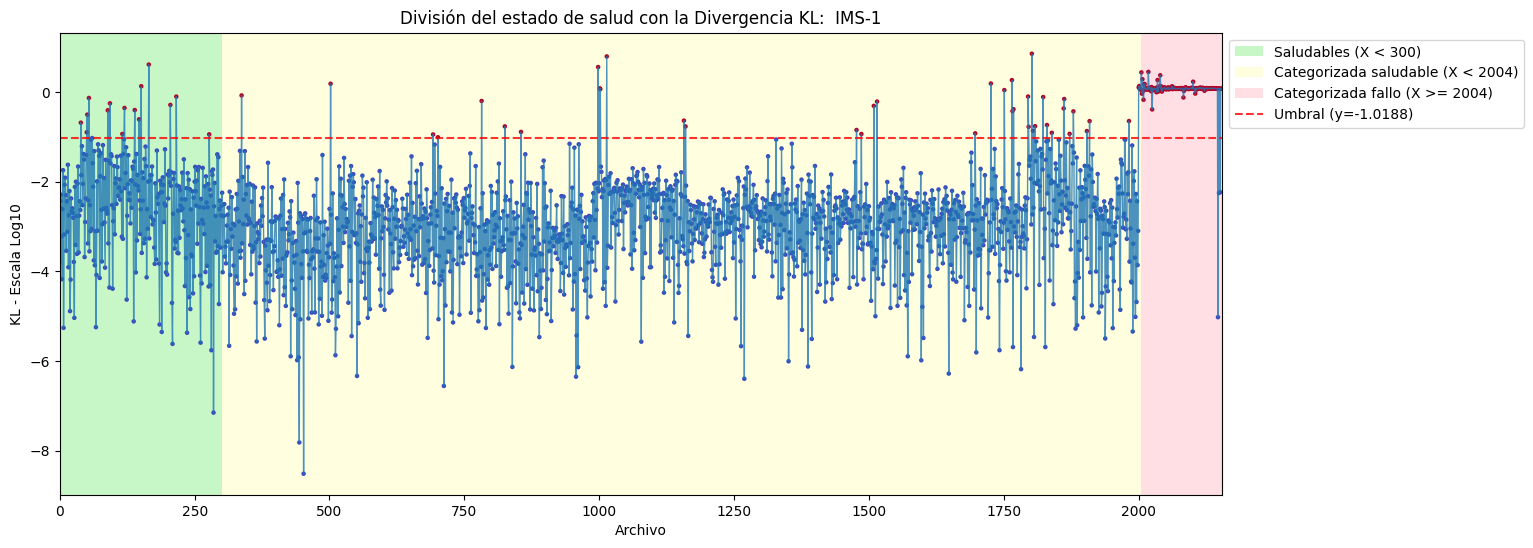

In [ ]:
plot_figure(
    df = kl_total,
    alarma=alarma,
    thr=thr,
    width=15,
    height=6,
    name=name,
    point_size=0.1,
    #ylim=0.05,
    #xlim_i=200,
    #xlim_s=500,
            )

In [ ]:
kl_total.to_csv(f"/content/drive/MyDrive/TFM/MeanVars/{name}-KL-GHD.csv")

## <a id='toc4_3_'></a>[Opc3: KL over Prior](#toc0_)

Same as before but N(0,1) and q(mu_z, var_z):

In [33]:
def kl_divergence(mu, var):
  #KLz = -0.5 * torch.sum(1 + torch.log(var) - mu.pow(2) - var)
  KLz = -0.5 * (1 + math.log(var) - math.pow(mu, 2) - var)

  return KLz

In [34]:
kl_total = data.apply(lambda x: kl_divergence(mu=x["mu_x"], var=x["var_x"]), axis=1)

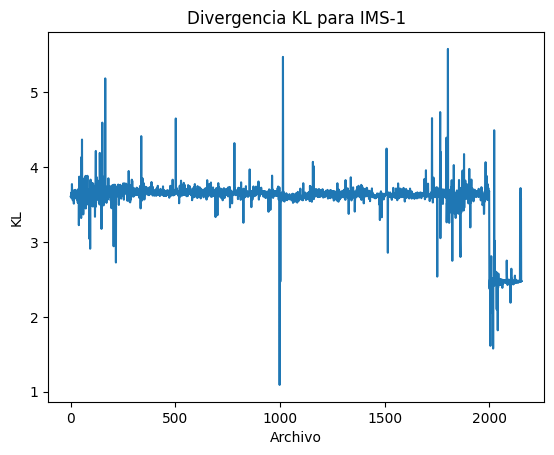

In [35]:
kl_total.plot()#kind='line', marker='o', grid=True)
plt.xlabel('Archivo')
plt.ylabel('KL')
plt.title('Divergencia KL para ' + name)
#plt.axhline(y=0.05, color='red', linestyle='--', label="Umbral (y=0.05)")
#plt.ylim(0, 5)
#plt.xlim(250,550)
plt.show()

In [ ]:
kl_total.to_csv(f"/content/drive/MyDrive/TFM/MeanVars/{name}-KS-PRIOR.csv")

## <a id='toc4_4_'></a>[Opc4: Entropy](#toc0_)

For Multivariate:

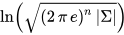



For univariate:

image.png

The determinant of a diagonal matrix (as is the case of my covariance matrix) is the product of its main diagonal, so I just need to compute it and is easy to generalize.

### <a id='toc4_4_1_'></a>[Computations](#toc0_)

In [ ]:
def entropy(vars):
  # vars: list of variances
  n = len(vars)

  first_term = math.pow(2*math.pi*math.e, n)
  determinant = math.prod(vars)

  root = math.sqrt(first_term * determinant)

  return math.log(root)



First, extract variances. 

N is the number of variances, so >1 when multivariate. N=1 and N=4 was used

In [59]:
n = 1

vars = data.iloc[:,n:]
vars

,var_x
0,3.433607e-04
1,1.761155e-03
2,6.888938e-04
3,6.103512e-03
4,2.056531e-04
...,...
485,7.818502e-09
486,3.473434e-08
487,2.875830e-06
488,8.312758e-09


In [ ]:
df_entropy = vars.apply(lambda x: entropy(x), axis=1)
df_entropy

,0
0,-2.569426
1,-1.751954
2,-2.221273
3,-1.130507
4,-2.825721
...,...
485,-7.914448
486,-7.168830
487,-4.960646
488,-7.883799


### <a id='toc4_4_2_'></a>[Result](#toc0_)

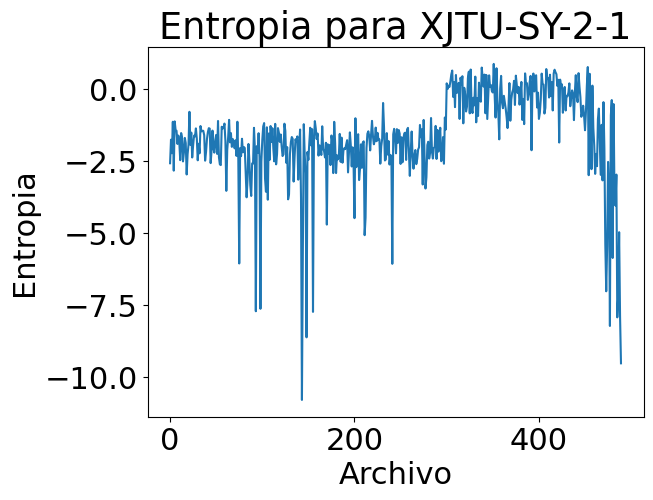

In [ ]:
df_entropy.plot()#kind='line', marker='o', grid=True)
plt.xlabel('Archivo')
plt.ylabel('Entropia')
plt.title('Entropia para ' + name)
#plt.axhline(y=0.05, color='red', linestyle='--', label="Umbral (y=0.05)")
#plt.ylim(0, 5)
#plt.xlim(250,550)
plt.show()

In [ ]:
df_entropy.to_csv(f"/content/drive/MyDrive/TFM/MeanVars/{name}-entropy.csv")

## <a id='toc4_5_'></a>[Opc5: Variance](#toc0_)

### <a id='toc4_5_1_'></a>[Computations](#toc0_)

In [ ]:
thr = np.percentile(healthy['var_x'], 95)
thr

0.056090654060244494

In [39]:
def percentil(thr, single_data):

  # Compara el valor p con el nivel de significancia (por ejemplo, 0.05)
  if single_data > thr:
    different = True
  else:
    different = False

  return different, single_data

In [40]:
res = data.apply(lambda x: percentil(thr=thr, single_data=x["var_x"]), axis=1)
data_ks = pd.DataFrame(res.tolist(), columns=['is_different', 'valor'])
data_ks['is_different'].value_counts()

,count
is_different,
False,1948
True,207


In [41]:
def get_alert(data, window_size, n_true):
  for i in range(len(data) - window_size + 1):
    window = data[i:i + window_size]
    if window.sum() >= 4:
      return i+window_size

  return -1

In [42]:
alarma = get_alert(data_ks['is_different'], 5,4)

In [43]:
font = {'size'   : 22}

plt.rc('font', **font)

In [ ]:
def plot_figure(df, alarma, thr, name, width, height, linewidth=1,point_size=5, ylim=None, xlim_i=None, xlim_s=None):
  fig, ax = plt.subplots(figsize=(width,height))

  x_values = range(len(df))
  y_values = df['valor']
  is_different = df['is_different']



  ax.axvspan(0, 300, facecolor='lightgreen', alpha=0.5, label='Saludables (X < 300)')
  ax.axvspan(300, alarma, facecolor='lightyellow', alpha=1, label=f'Categorizada saludable (X < {alarma})')
  ax.axvspan(alarma, len(df), facecolor='pink', alpha=0.5, label=f'Categorizada fallo (X >= {alarma})')

  # Gráfico de línea
  ax.plot(x_values, y_values, alpha=0.8, linewidth=1)

  # Gráfico de dispersión con puntos coloreados
  ax.scatter(x_values, y_values, c=is_different, cmap='coolwarm', s=5)



  # Agregar una línea horizontal en el valor de umbral
  ax.axhline(y=thr, color='red', linestyle='--', alpha=0.8, label=f"Umbral (y={thr:.4f})")

  # Agregar etiquetas y título
  ax.set_xlabel('Archivo')
  ax.set_ylabel('Varianza')
  ax.set_title(f'División del estado de salud con la Varianza:  {name}')
  if ylim is not None:
    ax.set_ylim(0, ylim)
  if xlim_i is None:
    ax.set_xlim(0, len(df))
  else:
    ax.set_xlim(xlim_i, xlim_s)

  # Agregar fondo de color según un valor específico de X (por ejemplo, X = 200)


  # Mostrar la leyenda
  ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


  # Mostrar el gráfico
  plt.show()

### <a id='toc4_5_2_'></a>[Result](#toc0_)

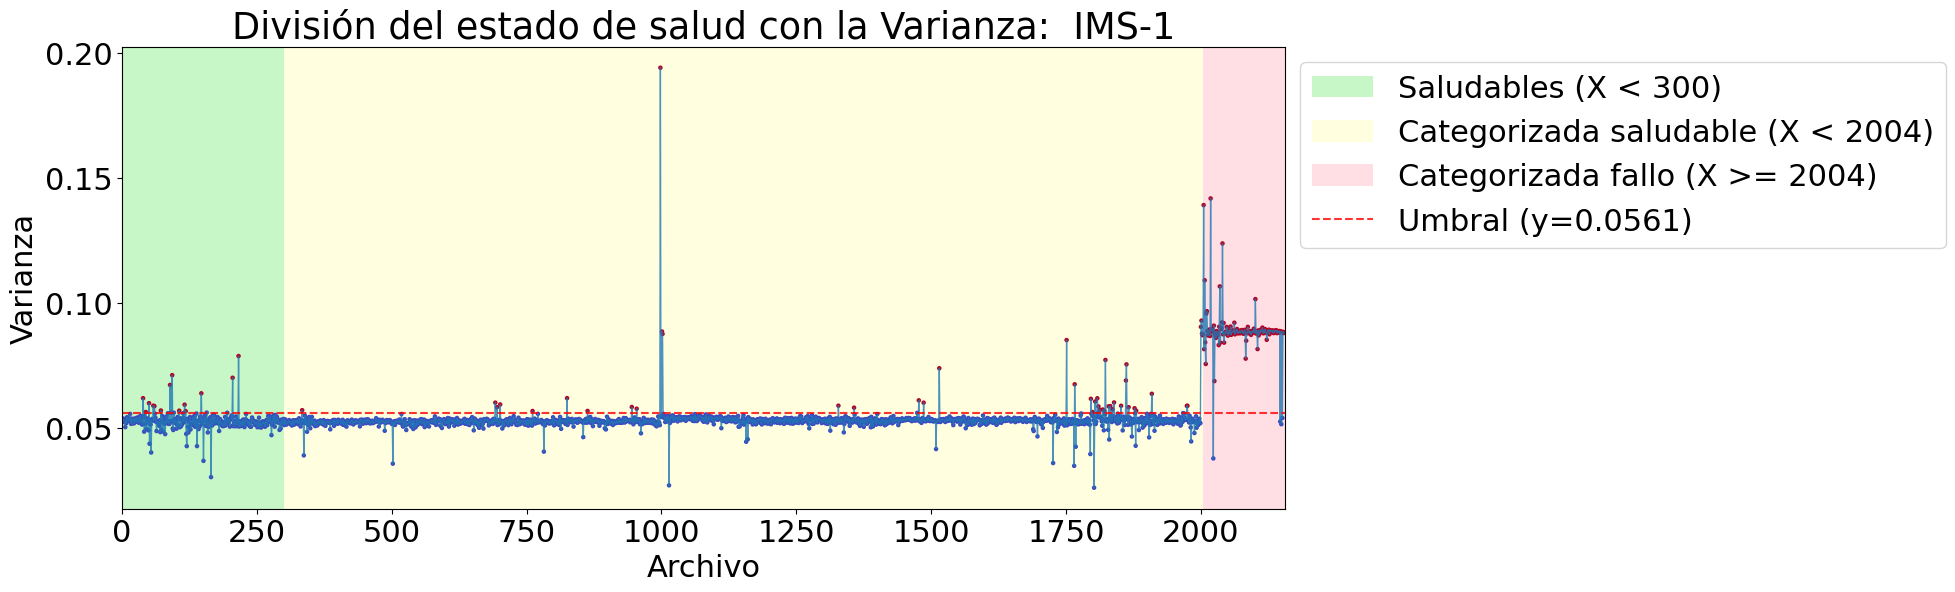

In [ ]:
plot_figure(
    df = data_ks,
    alarma=alarma,
    thr=thr,
    width=15,
    height=6,
    name=name,
    point_size=0.1,
    #ylim=0.05,
    #xlim_i=200,
    #xlim_s=500,
            )

In [46]:
data_ks

,is_different,valor
0,False,0.053659
1,False,0.053646
2,False,0.053669
3,False,0.053071
4,False,0.052319
...,...,...
2150,True,0.088165
2151,False,0.053946
2152,True,0.088404
2153,True,0.087899


In [47]:
data_ks.to_csv(f"/content/drive/MyDrive/TFM/MeanVars/{name}-variance-RESULTS.csv")